To validate our inter-flow correlation hypothesis, we performed a comprehensive statistical analysis.. The results shared here are for O/NO split $m=10$ which previously yielded the best predictive performance. Similar patterns were observed for $m=5$, albeit with slightly lower metric ranges (see notebook titled *Inter-Flow EDA (m in {5, 10})*)

We quantified the number of overlapping (covering) flows and characterized subsets sharing application category/type or containing SD events. We also measured the delay (in flow count and real time) required to encounter such flows, and for SD-labeled target flows, evaluated the SD-specific overlap quality.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# Setting working directory
import json
with open('setup.json', 'r') as openfile:
    setup_object = json.load(openfile)
    WD = setup_object["wd_path"]

In [3]:
# matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.family'] = 'DeJavu Serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 10

In [4]:
M = 10

# Flow Overlap Quantification

overlaps
count    12695.000000
mean      2836.206459
std       1425.195425
min         30.000000
25%       1817.500000
50%       2842.000000
75%       3769.000000
max       8944.000000
Name: count_overlaps, dtype: float64

overlapping_with_SDs
count    12695.000000
mean       290.932651
std        176.334400
min          0.000000
25%        159.000000
50%        284.000000
75%        419.000000
max        852.000000
Name: count_overlapping_SDs, dtype: float64

overlaps_same_appcat
count    12695.000000
mean      1713.313273
std       1072.004643
min          0.000000
25%        816.000000
50%       1703.000000
75%       2461.000000
max       6703.000000
Name: count_overlaps_same_appcat, dtype: float64

overlaps_same_app
count    12695.000000
mean      1067.100433
std        860.098427
min          0.000000
25%        196.000000
50%       1053.000000
75%       1655.000000
max       5615.000000
Name: count_overlaps_same_app, dtype: float64

overlaps_same_appcat_with_SD
count    12695.000

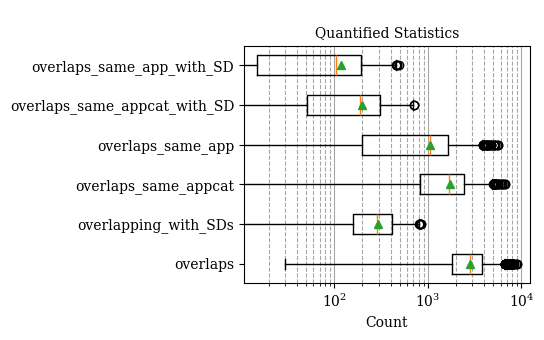

In [65]:
fig, a = plt.subplots(figsize=(5.5, 3.5))

df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet')
df_with_overlaps = df[df['overlapping_rel_idxs'].apply(len) > 0]
datas = [df_with_overlaps['count_overlaps'], df_with_overlaps['count_overlapping_SDs'],
         df_with_overlaps['count_overlaps_same_appcat'], df_with_overlaps['count_overlaps_same_app'],
         df_with_overlaps['count_overlaps_same_appcat_with_SD'], df_with_overlaps['count_overlaps_same_app_with_SD']]
labels = ['overlaps', 'overlapping_with_SDs', 'overlaps_same_appcat',
                  'overlaps_same_app', 'overlaps_same_appcat_with_SD',
                  'overlaps_same_app_with_SD']
with open(f"plots/inter_stats_used/quantified_statstics_M{M}.txt", 'w') as f:
        ...
for data, label in zip(datas, labels):
    with open(f"plots/inter_stats_used/quantified_statstics_M{M}.txt", 'a') as f:
        f.write(label + '\n')
        f.write(data.describe().to_string())
        f.write('\n\n')
    print(label)
    print(data.describe())
    print()
a.boxplot(datas, showmeans=True, vert=False)
a.set_xscale('log')
a.set_xlabel('Count')
a.set_yticks([i + 1 for i in range(6)])
a.set_yticklabels(labels)
a.set_title(f"\nQuantified Statistics", fontsize=10)
a.grid(True, which="minor", ls="--", c='0.65', axis='x')
a.grid(True, which="major", ls="-", c='0.65', axis='x')

fig.tight_layout()
plt.savefig(f"plots/inter_stats_used/quantified_statstics_M{M}.pdf")
plt.show()

Target flows are overlapped by a substantial number of other flows (mean = 2836.2, IQR: 1817.5–3769). Limiting to SD-containing overlaps reduces this to a mean of 290.9 (IQR: 159–419), reflecting the sparsity of relevant SD flows. Overlaps sharing application category or type averaged 1713.3 and 1067.1 respectively, with SD-containing subsets at 199.6 and 117.6. These results highlight the abundance of generic or category-matched covering flows. However, the presence of SD events even across multiple flows is significantly lower, underscoring the potential of the inter-flow approach.

In [80]:
def plot_boxplots_ecdfs_vert(ylabel, title, filename, get_datas, to_plot, labels,
                        log_xscale=False, showfliers=True, show_tick_labels=True, figsize=(5,5)
                       ):    
    fig, ax_box = plt.subplots(figsize=figsize)
    
    datas = get_datas(filename, M, to_plot)
    ax_box.set_title(title, fontsize=10)

    with open(f"{filename}.txt", 'w') as f:
        ...
    for data, label in zip(datas, labels):
        with open(f"{filename}.txt", 'a') as f:
            f.write(label + '\n')
            f.write(data.describe().to_string())
            f.write('\n\n')
        print(label)
        print(data.describe())
        print()

    ax_box.boxplot(datas, showmeans=True, vert=True, showfliers=showfliers)
    if log_xscale:
        ax_box.set_yscale('log')
    if show_tick_labels: 
        ax_box.set_xticks([i + 1 for i in range(len(labels))])
        ax_box.set_xticklabels(labels)   
    else:
        ax_box.set_xticklabels([])
        ax_box.set_xticks([])
    ax_box.grid(True, which="minor", ls="--", c='0.65', axis='y')
    ax_box.grid(True, which="major", ls="-", c='0.65', axis='y')
    ax_box.set_ylabel(ylabel)

    del datas

    fig.tight_layout()
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.show()

In [6]:
def plot_boxplots_ecdfs(xlabel, title, filename, get_datas, to_plot, labels,
                        log_xscale=False, showfliers=True, show_tick_labels=True, figsize=(5,5),
                        insert_empty_row=False
                       ):    
    fig, ax_box = plt.subplots(figsize=figsize)
    
    datas = get_datas(filename, M, to_plot)
    if insert_empty_row:
        datas.insert(0, pd.Series([]))
        labels.insert(0, '')
    ax_box.set_title(title, fontsize=10)

    with open(f"{filename}.txt", 'w') as f:
        ...
    for data, label in zip(datas, labels):
        with open(f"{filename}.txt", 'a') as f:
            f.write(label + '\n')
            f.write(data.describe().to_string())
            f.write('\n\n')
        print(label)
        print(data.describe())
        print()

    ax_box.boxplot(datas, showmeans=True, vert=False, showfliers=showfliers)
    if log_xscale:
        ax_box.set_xscale('log')
    if show_tick_labels: 
        ax_box.set_yticks([i + 1 for i in range(len(labels))])
        ax_box.set_yticklabels(labels)   
    else:
        ax_box.set_yticklabels([])
        ax_box.set_yticks([])
    ax_box.grid(True, which="minor", ls="--", c='0.65', axis='x')
    ax_box.grid(True, which="major", ls="-", c='0.65', axis='x')
    ax_box.set_xlabel(xlabel)

    del datas

    fig.tight_layout()
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.show()

In [8]:
def get_datas_min(filename, M, to_plot):
    plot_list = []
    for feature in to_plot:
        df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet', columns=[feature])
        plot_list.append(df[df[feature].apply(len) > 0][feature].apply(min))
        del df
    return plot_list

def get_datas_all(filename, M, to_plot):
    plot_list = []
    for feature in to_plot:
        df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet', columns=[feature])
        plot_list.append(pd.Series([item for row in df[feature] for item in row]))
        del df
    return plot_list

# Covering Flow Relative Index Distribution

rel_idxs
count    12695.000000
mean       756.361245
std        491.886590
min          1.000000
25%        420.000000
50%        751.000000
75%       1050.000000
max       3026.000000
Name: overlapping_rel_idxs, dtype: float64

rel_idxs_w_SD
count    12514.000000
mean       767.234298
std        495.572010
min          1.000000
25%        426.000000
50%        762.000000
75%       1063.000000
max       3041.000000
Name: overlapping_rel_idxs_with_SD, dtype: float64

rel_idxs_same_appcat
count    12691.000000
mean       760.067449
std        492.527981
min          1.000000
25%        425.000000
50%        755.000000
75%       1053.000000
max       3355.000000
Name: overlapping_rel_idxs_same_appcat, dtype: float64

rel_idxs_same_app
count    12529.000000
mean       813.809322
std        531.371729
min          1.000000
25%        471.000000
50%        794.000000
75%       1099.000000
max       5178.000000
Name: overlapping_rel_idxs_same_app, dtype: float64

rel_idxs_same_appcat_w_SD
cou

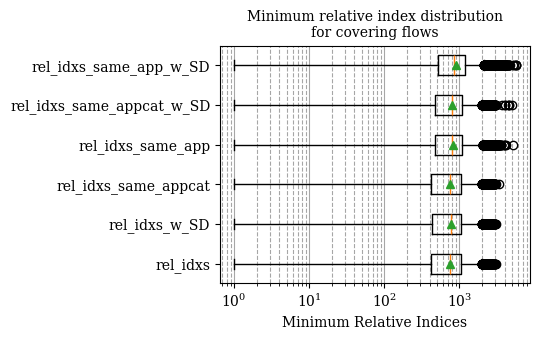

In [87]:
plot_boxplots_ecdfs(xlabel='Minimum Relative Indices',
                    title='Minimum relative index distribution\nfor covering flows',
                    filename='plots/inter_stats_used/minimum_relative_indices',
                    get_datas=get_datas_min,
                    to_plot = ['overlapping_rel_idxs', 'overlapping_rel_idxs_with_SD', 'overlapping_rel_idxs_same_appcat',
                               'overlapping_rel_idxs_same_app', 'overlapping_rel_idxs_same_appcat_with_SD', 'overlapping_rel_idxs_same_app_with_SD'],
                    labels = ['rel_idxs', 'rel_idxs_w_SD', 'rel_idxs_same_appcat',
                              'rel_idxs_same_app', 'rel_idxs_same_appcat_w_SD', 'rel_idxs_same_app_w_SD'],
                    log_xscale=True,
                    figsize=(5.5, 3.5)
                   )

The figure above shows the relative flow index to the first covering flow. The median index was 751, increasing slightly for category- and type-matched SD flows (842 and 789). Thus, examining the ~1000 flows (including non-covering ones) following a target is typically sufficient to include flows with all key characteristics.

rel_idxs
count    3.600564e+07
mean     1.775656e+03
std      1.285977e+03
min      0.000000e+00
25%      7.330000e+02
50%      1.555000e+03
75%      2.578000e+03
max      8.943000e+03
dtype: float64

rel_idxs_w_SD
count    3.687238e+06
mean     1.660723e+03
std      1.198060e+03
min      0.000000e+00
25%      6.810000e+02
50%      1.460000e+03
75%      2.424000e+03
max      8.658000e+03
dtype: float64

rel_idxs_same_appcat
count    2.175051e+07
mean     1.759228e+03
std      1.266941e+03
min      0.000000e+00
25%      7.340000e+02
50%      1.544000e+03
75%      2.550000e+03
max      8.943000e+03
dtype: float64

rel_idxs_same_app
count    2.534400e+06
mean     1.626974e+03
std      1.172097e+03
min      0.000000e+00
25%      6.690000e+02
50%      1.429000e+03
75%      2.375000e+03
max      8.376000e+03
dtype: float64

rel_idxs_same_appcat_w_SD
count    1.354684e+07
mean     1.770343e+03
std      1.265038e+03
min      0.000000e+00
25%      7.500000e+02
50%      1.559000e+03
75%      2.5

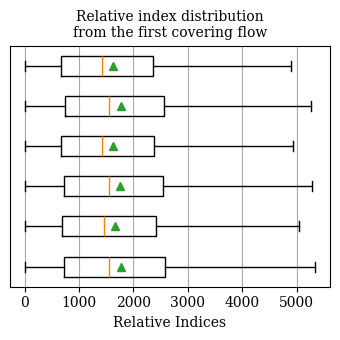

In [85]:
plot_boxplots_ecdfs(xlabel='Relative Indices',
                    title='Relative index distribution\nfrom the first covering flow',
                    filename='plots/inter_stats_used/relative_from_cover_start',
                    get_datas=get_datas_all,
                    to_plot = ['overlapping_rel_to_rel_idxs', 'overlapping_rel_to_rel_idxs_with_SD',
                               'overlapping_rel_to_rel_idxs_same_appcat', 'overlapping_rel_to_rel_idxs_same_appcat_with_SD',
                               'overlapping_rel_to_rel_idxs_same_app', 'overlapping_rel_to_rel_idxs_same_app_with_SD'],
                    labels = ['rel_idxs', 'rel_idxs_w_SD', 'rel_idxs_same_appcat',
                               'rel_idxs_same_app', 'rel_idxs_same_appcat_w_SD', 'rel_idxs_same_app_w_SD'],
                    showfliers=False,
                    show_tick_labels=False,
                    figsize=(3.5, 3.5)
                   )

The figure above illustrates the distribution of covering flows after the first overlap. These were broadly distributed across the next 700–4000 flows, with relative indices generally uniform.


count       0
unique      0
top       NaN
freq      NaN
dtype: object

rel_idxs_w_SD
count    12514.000000
mean        12.204411
std         17.909620
min          0.000000
25%          2.000000
50%          7.000000
75%         16.000000
max        261.000000
Name: overlapping_rel_to_rel_idxs_with_SD, dtype: float64

rel_idxs_same_appcat
count    12691.000000
mean         3.777874
std         31.216939
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1451.000000
Name: overlapping_rel_to_rel_idxs_same_appcat, dtype: float64

rel_idxs_same_app
count    12396.000000
mean        45.043966
std        151.901529
min          0.000000
25%          3.000000
50%         11.000000
75%         30.000000
max       3717.000000
Name: overlapping_rel_to_rel_idxs_same_appcat_with_SD, dtype: float64

rel_idxs_same_appcat_w_SD
count    12529.000000
mean        56.189640
std        243.437407
min          0.000000
25%          0.000000
50%          1.000

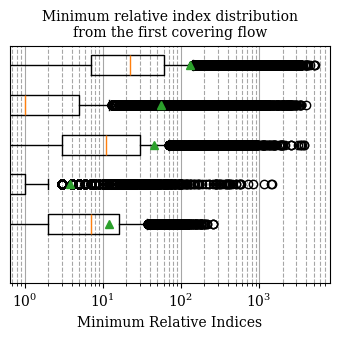

In [86]:
plot_boxplots_ecdfs(xlabel='Minimum Relative Indices',
                    title='Minimum relative index distribution\nfrom the first covering flow',
                    filename='plots/inter_stats_used/minimum_relative_from_cover_start',
                    get_datas=get_datas_min,
                    to_plot = ['overlapping_rel_to_rel_idxs_with_SD',
                       'overlapping_rel_to_rel_idxs_same_appcat', 'overlapping_rel_to_rel_idxs_same_appcat_with_SD',
                       'overlapping_rel_to_rel_idxs_same_app', 'overlapping_rel_to_rel_idxs_same_app_with_SD'],
                    labels = ['rel_idxs_w_SD', 'rel_idxs_same_appcat',
                               'rel_idxs_same_app', 'rel_idxs_same_appcat_w_SD', 'rel_idxs_same_app_w_SD'],
                    log_xscale=True,
                    show_tick_labels=False,
                    figsize=(3.5, 3.5),
                    insert_empty_row=True
                   )

This view focuses on the minimum relative index needed to find another matching covering flow after the first. Same-category flows were almost found immediately (median = 0, mean = 3.8, SD = 31). Flows with SD events and matching types had higher medians (22–61), indicating moderate sparsity. Overall, even though covering flow relative indices have a wide distribution, flows with the same application type and SD event included will be encountered in under 60 covering flows in most cases.

# Covering Flow Relative Time Distribution

A complementary view of the relative covering indices comes from the measurement of relative time between the target flow and its covering flows.

rel_time
count    3.600564e+07
mean     5.749440e+05
std      3.576532e+05
min      2.100000e+01
25%      2.827680e+05
50%      5.328090e+05
75%      8.300160e+05
max      1.799745e+06
dtype: float64

rel_time_w_SD
count    3.687238e+06
mean     7.110327e+05
std      3.385259e+05
min      2.618100e+04
25%      4.373960e+05
50%      6.704245e+05
75%      9.520080e+05
max      1.799745e+06
dtype: float64

rel_time_same_appcat
count    2.175051e+07
mean     5.786161e+05
std      3.553197e+05
min      2.100000e+01
25%      2.906190e+05
50%      5.387840e+05
75%      8.317500e+05
max      1.799745e+06
dtype: float64

rel_time_same_app
count    1.354684e+07
mean     5.876094e+05
std      3.564756e+05
min      2.100000e+01
25%      2.997690e+05
50%      5.496760e+05
75%      8.421450e+05
max      1.799745e+06
dtype: float64

rel_time_same_appcat_w_SD
count    2.534400e+06
mean     7.073852e+05
std      3.337967e+05
min      3.050300e+04
25%      4.372960e+05
50%      6.662640e+05
75%      9.4

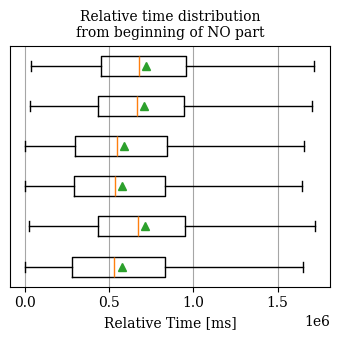

In [117]:
plot_boxplots_ecdfs(xlabel='Relative Time [ms]',
                    title='Relative time distribution\nfrom beginning of NO part',
                    filename='plots/inter_stats_used/relative_time',
                    get_datas=get_datas_all,
                    to_plot = ['overlapping_rel_time',
                           'overlapping_rel_time_with_SD', 'overlapping_rel_time_same_appcat',
                           'overlapping_rel_time_same_app',
                           'overlapping_rel_time_same_appcat_with_SD',
                           'overlapping_rel_time_same_app_with_SD'],
                    labels = ['rel_time', 'rel_time_w_SD', 'rel_time_same_appcat',
                               'rel_time_same_app', 'rel_time_same_appcat_w_SD', 'rel_time_same_app_w_SD'],
                    showfliers=False,
                    show_tick_labels=False,
                    figsize=(3.5, 3.5)
                   )

The figure above shows broader time distributions between covering flows, with medians around 500–700 s. SD-containing flows required even longer intervals, reinforcing the value of extracting context from early, SD-free overlaps.

NO time
count    2.388450e+05
mean     1.899112e+05
std      3.522388e+05
min      0.000000e+00
25%      1.110000e+02
50%      2.515600e+04
75%      1.849240e+05
max      1.798056e+06
dtype: float64



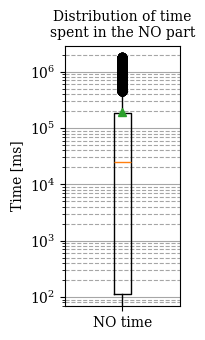

In [81]:
def get_NO_len(filename, M, to_plot):
    df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet', columns=['NO_delay', 'NO_timestamps'])
    df = df[df['NO_delay'].apply(len) > 0]
    return [df.apply(lambda row: (row['NO_timestamps'][-1] + row['NO_delay'][-1]) - row['NO_timestamps'][0], axis=1)]

plot_boxplots_ecdfs_vert(ylabel='Time [ms]',
                    title='Distribution of time\nspent in the NO part',
                    filename='plots/inter_stats_used/NO_time',
                    log_xscale=True,
                    get_datas=get_NO_len,
                    to_plot = ['NO_time'],
                    labels = ['NO time'],
                    figsize=(2, 3.5)
                   )

This figure shows the duration of the NO segments. The distribution exhibits a heavy tail (mean = 190 seconds, max > 28 minutes), indicating wide variability in NO lengths. This means that the minority of flows were expired by active timeout with most flows lasting for under a few minutes.

rel_time
count    12695.000000
mean      1426.875463
std       1256.722107
min         21.000000
25%        553.000000
50%       1076.000000
75%       1905.000000
max      15887.000000
Name: overlapping_rel_time, dtype: float64

rel_time_w_SD
count     12514.000000
mean      98479.650072
std       30837.916675
min       26181.000000
25%       75330.750000
50%       97315.500000
75%      116914.250000
max      247468.000000
Name: overlapping_rel_time_with_SD, dtype: float64

rel_time_same_appcat
count     12691.000000
mean       3723.226302
std       13106.135780
min          21.000000
25%         799.000000
50%        1650.000000
75%        3184.500000
max      573253.000000
Name: overlapping_rel_time_same_appcat, dtype: float64

rel_time_same_app
count    1.252900e+04
mean     2.733848e+04
std      9.436940e+04
min      2.100000e+01
25%      1.211000e+03
50%      2.814000e+03
75%      7.098000e+03
max      1.138472e+06
Name: overlapping_rel_time_same_app, dtype: float64

rel_time_same

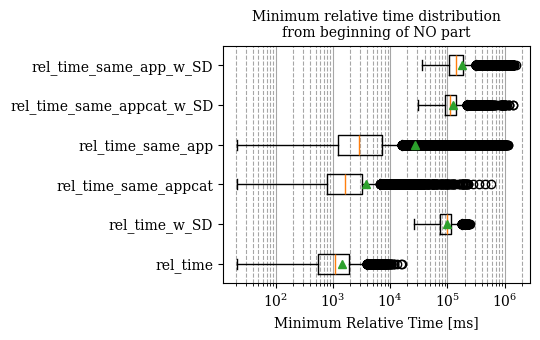

In [115]:
plot_boxplots_ecdfs(xlabel='Minimum Relative Time [ms]',
                    title='Minimum relative time distribution\nfrom beginning of NO part',
                    filename='plots/inter_stats_used/minimum_relative_time',
                    get_datas=get_datas_min,
                    to_plot = ['overlapping_rel_time',
                           'overlapping_rel_time_with_SD', 'overlapping_rel_time_same_appcat',
                           'overlapping_rel_time_same_app',
                           'overlapping_rel_time_same_appcat_with_SD',
                           'overlapping_rel_time_same_app_with_SD'],
                    labels = ['rel_time', 'rel_time_w_SD', 'rel_time_same_appcat',
                               'rel_time_same_app', 'rel_time_same_appcat_w_SD', 'rel_time_same_app_w_SD'],
                    log_xscale=True,
                    show_tick_labels=True,
                    figsize=(5.5, 3.5)
                   )

In temporal terms, the figure above shows that the mean delay to the first covering flow was 1.43 seconds, while SD-containing flows exhibited far longer delays—averaging 98 s, and up to 179 s for type-matched SD overlaps. Therefore, while generic overlaps occur quickly, relevant SD overlaps often require tens of seconds to minutes, by which point many target flows may have ended—highlighting the need for early detection based on non-SD flows.

# SD Event Coverage Statistics


count    1.251400e+04
mean    -1.338702e+05
std      2.377177e+05
min     -1.525109e+06
25%     -1.581515e+05
50%     -6.598975e+04
75%      9.087750e+03
max      1.399580e+05
Name: SDs_center_distances, dtype: float64



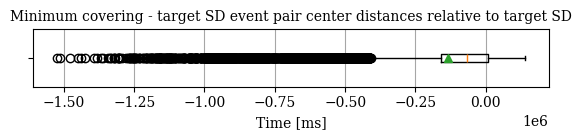

In [9]:
plot_boxplots_ecdfs(xlabel='Time [ms]',
                    title='Minimum covering - target SD event pair center distances relative to target SD',
                    filename='plots/inter_stats_used/SD_center_distances',
                    get_datas=get_datas_min,
                    to_plot = ['SDs_center_distances'],
                    labels = [''],
                    log_xscale=False,
                    show_tick_labels=True,
                    figsize=(5.5, 1.5)
                   )


To assess the quality of SD event capture within the correlation window, we examined the *SD coverage* metric-the maximum of relative lengths of any overlapping SD event in the covering flow to the length of any target SD event. This metric provides an upper bound on how well SD activity in the target flow is temporally mirrored, regardless of perfect alignment. The results, summarized in the figure above, indicate generally low but highly variable coverage levels with an average relative coverage was 0.24 (median = 0.13), indicating that most overlaps capture less than 25\% of the target SD duration. Notably, the distribution is right-skewed, with the upper quartile reaching 0.31 and rare cases achieving coverages above $1$ due to shorter targets or longer overlaps. These findings reinforce the challenge of capturing full SD events through inter-flow correlation alone and underscore the necessity of integrating multiple covering flows to reconstruct the SD activity of the target flow effectively.


count    12514.000000
mean         0.240852
std          0.242263
min          0.013335
25%          0.081726
50%          0.133782
75%          0.308737
max          3.839157
Name: SDs_covering_portions, dtype: float64



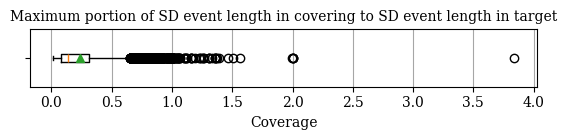

In [114]:
plot_boxplots_ecdfs(xlabel='Coverage',
                    title='Maximum portion of SD event length in covering to SD event length in target',
                    filename='plots/inter_stats_used/SD_coverages',
                    get_datas=get_datas_min,
                    to_plot = ['SDs_covering_portions'],
                    labels = [''],
                    log_xscale=False,
                    show_tick_labels=True,
                    figsize=(5.5, 1.5)
                   )

We also measured *SD center distance*, i.e. the temporal offset between the center of a target SD event and its best covering SD event within the correlation window. The distribution was skewed negative (mean = –133 s; median = –66 s; IQR: –158 to 9 s), indicating that overlaps often precede the target SD. Extremes ranged from 25 minutes early to over 2 minutes late, likely reflecting unrelated SD events due to the sparse alignment.

These findings highlight both the potential and limitations of inter-flow SD inference. While temporal misalignment is frequent, the presence of early SDs in covering flows offers a viable opportunity for real-time detection, especially when combined across multiple partial overlaps.